# 수치입력 다중클래스분류모델 레시피
수치를 입력해서 다중클래스를 분류할 수 있는 모델들에 대하여 알아보겠다.<br>
다중클래스분류를 위한 데이터셋을 생성해보고 가장 간단한 퍼셉트론 신경망 모델부터 깊은 다층퍼셉트론 신경망 모델까지 구성 및 학습을 해보겠다.<br>
<br>
### 1. 데이터셋 준비
훈련에 사용할 임의의 값을 가진 인자 12개로 구성된 입력(x) 1000개와 각 입력에 대해 0에서 9까지 10개의 값 중 임의로 지정된 출력(y)을 가지는 데이터셋을 생성해보겠다.

In [1]:
import numpy as np

#데이터셋 생성
x_train = np.random.random((1000, 12)) # 1000 x 12 행렬 생성
y_train = np.random.randint(10, size=(1000,1)) # 0과 1사이 난수 생성, size는 1000x1 행렬
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100,1))

데이터셋의 12개 인자(x) 및 라벨값(y) 모두 무작위 수이다.<br>
패턴이 없는 데이터이고 학습하기에는 가장 어려운 케이스이다.<br>
패턴이 없기 때문에 이런 데이터로 학습한 모델은 시험셋에서 정확도가 상당히 낮다. 하지만 쓰는 이유는 다음과 같다.<br>

1. 패턴이 없는 데이터에서 각 모델들이 얼마나 빨리 학습되는지 살펴볼 수 있다.<br>
2. 실제 데이터를 사용하기 전에 데이터셋 형태를 설계하거나 모델 프로토타입핑하기에 적절하다.

12개 입력 인자 중 첫 번째와 두 번째 인자 값만 이용하여 2차원으로 데이터 분포를 살펴보겠다.

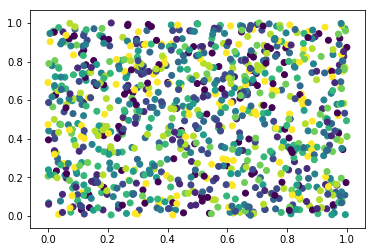

In [2]:
#데이터셋 확인(2차원)

%matplotlib inline
import matplotlib.pyplot as plt

plot_x = x_train[:,0]
plot_y = x_train[:,1]
plot_color = y_train.reshape(1000,) # 2차원이므로 색깔이 2개로 구분해서 나온다.

plt.scatter(plot_x, plot_y, c=plot_color)
plt.show()

실제 데이터에서 첫 번째 인자와 두 번째 인자 사이에 상관관계가 있다면 그래프에서는 패턴을 볼 수 있다.<br>
현재는 임의의 값으로 데이터셋을 만들었으므로 예상대로 패턴을 찾을 수 없다.<br>
아래는 3번째 인자를 추가하여 3차원 그래프를 확인해보았다.

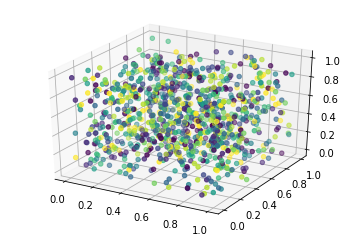

In [3]:
#데이터셋 확인(3차원)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # 111 = (1,1,1)

plot_x = x_train[:,0]
plot_y = x_train[:,1]
plot_z = x_train[:,2]
plot_color = y_train.reshape(1000,)

ax.scatter(plot_x, plot_y, plot_z, c=plot_color)
plt.show()

### 2. 데이터셋 전처리
이진분류인 경우, 학습 시에는 0과1로 값이 지정되면 예측 시에는 0.0과 1.0사이의 실수로 확률값이 출력된다.<br>
하지만 **다중클래스분류**인 경우 클래스별로 확률값을 지정하기 위해서는 **one-hot 인코딩**을 사용한다.<br>

- one-hot 인코딩
클래스가 3개일 때, 3개의 값을 가지는 행벡터로 구성하는 것을 의미한다.<br>
삼각형, 사각형, 원을 구분한다고 했을 때, 학습 시에 삼각형 라벨은 [1 0 0], 사각형 라벨은 [0 1 0], 원은 [0 0 1]로 지정한다.<br>
출력 또한 3개의 값을 가지는 헹벡터로 나오는데, 만약 [0.2 0.1 0.7]로 나왔다면 삼각형일 확률 20% 사각형 10% 원 70%을 뜻한다.<br>
이를 모두 더하면 100%다.<br>
<br>
one-hot 인코딩은 아래 코드와 같이 케라스에서 제공하는 "to_categorical()" 함수로 쉽게 처리할 수 있다.<br>
    
    
        y_train = np.random.randint(10,size=(1000,1))
        y_train = to_categorical(y_train, num_classes=10) #one-hot 인코딩 
        
        y_test = np.random.randint(10,size=(100,1))
        y_test = to_categorical(y_train, num_classes=10) #one-hot 인코딩
    

### 3. 레이어 준비
- softmax

활성화 함수로 입력되는 값을 클래스별로 확률 값이 나오도록 출력시킨다.<br>
이 확률값을 모두 더하면 1이다.<br>
다중클래스 모델의 출력층에 주로 사용되며 확률값이 가장 높은 클래스가 모델이 분류한 클래스이다.

### 4. 모델 준비
다중클래스분류를 하기 위해 퍼셉트론 신경망 모델, 다층퍼셉트론 신경망 모델, 깊은 다층퍼셉트론 신경망 모델을 준비하였다.<br>
<br>
- 퍼셉트론 신경망 모델

Dense 레이어가 하나이고 뉴런의 수도 하나인 가장 기본적인 퍼셉트론 신경망 모델이다.<br>
weight(w) 하나, bias(b) 하나로 전형적인 **Y = w x X +b**를 풀기 위한 모델이다.<br>
다중클래스분류이므로 출력 레이어는 softmax 활성화 함수를 사용하였다.

    model = Sequential()
    model.add(Dense(10, input_dim=12, activation='softmax'))

또는 활성화 함수를 블록을 쌓듯이 별도 레이어로 구성해도 좋다. 어차피 동일한 모델이다.

    model = Sequential()
    model.add(Dense(10, input_dim=12))
    model.add(Activation('softmax'))
    
<br>  
- 다층퍼셉트론 신경망 모델
Dense 레이어가 두 개인 다층퍼셉트론 신경망 모델이다.<br>
첫 번째 레이어는 64개의 뉴런을 가진 Dense 레이어고 오류 역전파가 용이한 relu 활성화 함수를 사용하였다.<br>
출력 레이어인 두 번째 레이어는 클래스별로 확률값을 출력하기 위해 10개의 뉴런과 softmax 활성화 함수를 사용하였다.<br>

    model = Sequential()
    model.add(Dense(64, input_dim=12, activation='relu'))
    model.add(Dense(10, activation='softmax'))    
    
- 깊은 다층퍼셉트론 신경망 모델
Dense 레이어가 총 3개인 다층퍼셉트론 신경망 모델이다.<br>
첫 번째, 두 번째 레이어는 총 64개의 뉴런을 가진 Dense 레이어이고 오류 역전파가 용이한 relu 활성화 함수를 사용하였다.<br>
출력 레이어인 세 번째 레이어는 클래스별 확률값을 출력하기 위해 10개의 뉴런과 softmax 활성화 함수를 사용하였다.

    model = Sequential()
    model.add(Dense(64, input_dim=12, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

### 5. 전체 소스






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1000





1000/1000 [==============================] - 1s 1ms/step - loss: 2.4930 - acc: 0.0780
Epoch 2/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.4618 - acc: 0.0740
Epoch 3/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.4389 - acc: 0.0790
Epoch 4/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.4201 - acc: 0.0820
Epoch 5/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.4034 - acc: 0.0870
Epoch 6/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.3890 - acc: 0.0980
Epoch 7/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.3766 - acc: 0.0960
Epoch 8/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.3664 - acc: 0.0990
Epoch 9/1000
1000/1000 [==============================] - 0s 16us/step - loss: 2.3575 - acc: 0

1000/1000 [==============================] - 0s 12us/step - loss: 2.2755 - acc: 0.1470
Epoch 132/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2752 - acc: 0.1490
Epoch 133/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2750 - acc: 0.1440
Epoch 134/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2747 - acc: 0.1480
Epoch 135/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2743 - acc: 0.1490
Epoch 136/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2744 - acc: 0.1520
Epoch 137/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2742 - acc: 0.1470
Epoch 138/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2740 - acc: 0.1500
Epoch 139/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2736 - acc: 0.1480
Epoch 140/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2736 - acc: 0.

1000/1000 [==============================] - 0s 15us/step - loss: 2.2643 - acc: 0.1490
Epoch 212/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2643 - acc: 0.1540
Epoch 213/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2640 - acc: 0.1530
Epoch 214/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2640 - acc: 0.1490
Epoch 215/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2639 - acc: 0.1520
Epoch 216/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2640 - acc: 0.1560
Epoch 217/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2637 - acc: 0.1510
Epoch 218/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2638 - acc: 0.1550
Epoch 219/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2636 - acc: 0.1530
Epoch 220/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2636 - acc: 0.

1000/1000 [==============================] - 0s 13us/step - loss: 2.2578 - acc: 0.1560
Epoch 372/1000
1000/1000 [==============================] - ETA: 0s - loss: 2.2451 - acc: 0.250 - 0s 14us/step - loss: 2.2578 - acc: 0.1560
Epoch 373/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2578 - acc: 0.1540
Epoch 374/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2578 - acc: 0.1570
Epoch 375/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2579 - acc: 0.1550
Epoch 376/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2578 - acc: 0.1580
Epoch 377/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2575 - acc: 0.1610
Epoch 378/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2577 - acc: 0.1570
Epoch 379/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2577 - acc: 0.1560
Epoch 380/1000
1000/1000 [==============================] -

1000/1000 [==============================] - 0s 13us/step - loss: 2.2569 - acc: 0.1580
Epoch 452/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2568 - acc: 0.1540
Epoch 453/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2569 - acc: 0.1520
Epoch 454/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2570 - acc: 0.1580
Epoch 455/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2569 - acc: 0.1560
Epoch 456/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2570 - acc: 0.1510
Epoch 457/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2570 - acc: 0.1540
Epoch 458/1000
1000/1000 [==============================] - 0s 11us/step - loss: 2.2566 - acc: 0.1540
Epoch 459/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2569 - acc: 0.1530
Epoch 460/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2568 - acc: 0.

1000/1000 [==============================] - 0s 13us/step - loss: 2.2560 - acc: 0.1600
Epoch 611/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2563 - acc: 0.1550
Epoch 612/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2560 - acc: 0.1600
Epoch 613/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2561 - acc: 0.1590
Epoch 614/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2560 - acc: 0.1540
Epoch 615/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2560 - acc: 0.1610
Epoch 616/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2562 - acc: 0.1550
Epoch 617/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2560 - acc: 0.1560
Epoch 618/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2561 - acc: 0.1600
Epoch 619/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2562 - acc: 0.

1000/1000 [==============================] - 0s 13us/step - loss: 2.2556 - acc: 0.1580
Epoch 771/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2559 - acc: 0.1550
Epoch 772/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2557 - acc: 0.1550
Epoch 773/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2559 - acc: 0.1580
Epoch 774/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2557 - acc: 0.1550
Epoch 775/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2558 - acc: 0.1570
Epoch 776/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2556 - acc: 0.1540
Epoch 777/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2557 - acc: 0.1590
Epoch 778/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2558 - acc: 0.1540
Epoch 779/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2556 - acc: 0.

1000/1000 [==============================] - 0s 13us/step - loss: 2.2554 - acc: 0.1580
Epoch 931/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2555 - acc: 0.1520
Epoch 932/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2554 - acc: 0.1530
Epoch 933/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2557 - acc: 0.1530
Epoch 934/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2553 - acc: 0.1580
Epoch 935/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2556 - acc: 0.1550
Epoch 936/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.2554 - acc: 0.1560
Epoch 937/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2554 - acc: 0.1570
Epoch 938/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2554 - acc: 0.1530
Epoch 939/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2554 - acc: 0.

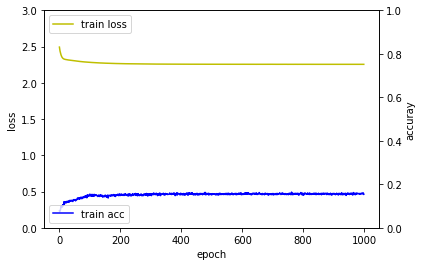

100/100 [==============================] - 0s 216us/step
loss_and_metrics : [2.4192175483703613, 0.04]


In [2]:
# 퍼셉트론 신경망 모델

# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import random

# 1. 데이터셋 생성하기
x_train = np.random.random((1000, 12))
y_train = np.random.randint(10, size=(1000, 1))
y_train = np_utils.to_categorical(y_train, num_classes=10) # one-hot 인코딩
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100, 1))
y_test = np_utils.to_categorical(y_test, num_classes=10) # one-hot 인코딩

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(10, input_dim=12, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=1000, batch_size=64)

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 3.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))


Epoch 1/1000
1000/1000 [==============================] - 0s 135us/step - loss: 2.3237 - acc: 0.0890
Epoch 2/1000
1000/1000 [==============================] - 0s 16us/step - loss: 2.3089 - acc: 0.1110
Epoch 3/1000
1000/1000 [==============================] - 0s 16us/step - loss: 2.3053 - acc: 0.1230
Epoch 4/1000
1000/1000 [==============================] - 0s 16us/step - loss: 2.3031 - acc: 0.1150
Epoch 5/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.3006 - acc: 0.1230
Epoch 6/1000
1000/1000 [==============================] - 0s 16us/step - loss: 2.2987 - acc: 0.1110
Epoch 7/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2967 - acc: 0.1290
Epoch 8/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2941 - acc: 0.1150
Epoch 9/1000
1000/1000 [==============================] - 0s 16us/step - loss: 2.2924 - acc: 0.1300
Epoch 10/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2906 - acc: 0.132

1000/1000 [==============================] - 0s 14us/step - loss: 2.1322 - acc: 0.2350
Epoch 163/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.1305 - acc: 0.2360
Epoch 164/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.1306 - acc: 0.2280
Epoch 165/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.1285 - acc: 0.2320
Epoch 166/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.1280 - acc: 0.2240
Epoch 167/1000
1000/1000 [==============================] - 0s 17us/step - loss: 2.1271 - acc: 0.2380
Epoch 168/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.1265 - acc: 0.2270
Epoch 169/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.1258 - acc: 0.2270
Epoch 170/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.1254 - acc: 0.2330
Epoch 171/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.1229 - acc: 0.

1000/1000 [==============================] - 0s 14us/step - loss: 2.0061 - acc: 0.2840
Epoch 323/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.0057 - acc: 0.2870
Epoch 324/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.0046 - acc: 0.2790
Epoch 325/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.0028 - acc: 0.2740
Epoch 326/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.0050 - acc: 0.2850
Epoch 327/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.0024 - acc: 0.2810
Epoch 328/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.0027 - acc: 0.2840
Epoch 329/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.0012 - acc: 0.2840
Epoch 330/1000
1000/1000 [==============================] - 0s 13us/step - loss: 2.0014 - acc: 0.2800
Epoch 331/1000
1000/1000 [==============================] - 0s 13us/step - loss: 1.9999 - acc: 0.

1000/1000 [==============================] - 0s 14us/step - loss: 1.9553 - acc: 0.3000
Epoch 403/1000
1000/1000 [==============================] - 0s 13us/step - loss: 1.9555 - acc: 0.2920
Epoch 404/1000
1000/1000 [==============================] - 0s 13us/step - loss: 1.9556 - acc: 0.2990
Epoch 405/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.9541 - acc: 0.3020
Epoch 406/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.9528 - acc: 0.2900
Epoch 407/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.9523 - acc: 0.3030
Epoch 408/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.9534 - acc: 0.2910
Epoch 409/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.9515 - acc: 0.3050
Epoch 410/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.9511 - acc: 0.3020
Epoch 411/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.9508 - acc: 0.

1000/1000 [==============================] - 0s 14us/step - loss: 1.8769 - acc: 0.3370
Epoch 563/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8757 - acc: 0.3370
Epoch 564/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8766 - acc: 0.3310
Epoch 565/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8768 - acc: 0.3380
Epoch 566/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8741 - acc: 0.3380
Epoch 567/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8760 - acc: 0.3390
Epoch 568/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8728 - acc: 0.3440
Epoch 569/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8740 - acc: 0.3310
Epoch 570/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8746 - acc: 0.3360
Epoch 571/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8734 - acc: 0.

1000/1000 [==============================] - 0s 17us/step - loss: 1.8146 - acc: 0.3590
Epoch 723/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.8134 - acc: 0.3630
Epoch 724/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.8135 - acc: 0.3610
Epoch 725/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.8136 - acc: 0.3730
Epoch 726/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.8131 - acc: 0.3680
Epoch 727/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.8132 - acc: 0.3680
Epoch 728/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.8101 - acc: 0.3680
Epoch 729/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.8116 - acc: 0.3680
Epoch 730/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.8103 - acc: 0.3690
Epoch 731/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.8095 - acc: 0.

1000/1000 [==============================] - 0s 12us/step - loss: 1.7865 - acc: 0.3820
Epoch 803/1000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7879 - acc: 0.3760
Epoch 804/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7873 - acc: 0.3820
Epoch 805/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.7839 - acc: 0.3870
Epoch 806/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7883 - acc: 0.3720
Epoch 807/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7862 - acc: 0.3850
Epoch 808/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7837 - acc: 0.3840
Epoch 809/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7885 - acc: 0.3730
Epoch 810/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7862 - acc: 0.3840
Epoch 811/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7831 - acc: 0.

1000/1000 [==============================] - 0s 15us/step - loss: 1.7431 - acc: 0.3970
Epoch 963/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.7433 - acc: 0.3950
Epoch 964/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7443 - acc: 0.3930
Epoch 965/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.7439 - acc: 0.3890
Epoch 966/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.7412 - acc: 0.3890
Epoch 967/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.7445 - acc: 0.3980
Epoch 968/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.7421 - acc: 0.3920
Epoch 969/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.7418 - acc: 0.4070
Epoch 970/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.7429 - acc: 0.3990
Epoch 971/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.7414 - acc: 0.

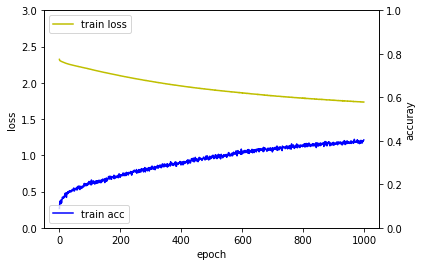

100/100 [==============================] - 0s 363us/step
loss_and_metrics : [3.012681064605713, 0.12]


In [4]:
# 다층퍼셉트론 신경망 모델

# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 12))
y_train = np.random.randint(10, size=(1000, 1))
y_train = to_categorical(y_train, num_classes=10) # one-hot 인코딩
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100, 1))
y_test = to_categorical(y_test, num_classes=10) # one-hot 인코딩

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=12, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=1000, batch_size=64)

# 5. 학습과정 확인하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 3.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))


Epoch 1/1000
1000/1000 [==============================] - 0s 197us/step - loss: 2.3137 - acc: 0.1010
Epoch 2/1000
1000/1000 [==============================] - 0s 18us/step - loss: 2.2964 - acc: 0.1070
Epoch 3/1000
1000/1000 [==============================] - 0s 16us/step - loss: 2.2909 - acc: 0.1330
Epoch 4/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2872 - acc: 0.1270
Epoch 5/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2828 - acc: 0.1500
Epoch 6/1000
1000/1000 [==============================] - 0s 15us/step - loss: 2.2784 - acc: 0.1420
Epoch 7/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2759 - acc: 0.1500
Epoch 8/1000
1000/1000 [==============================] - 0s 12us/step - loss: 2.2724 - acc: 0.1550
Epoch 9/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2683 - acc: 0.1560
Epoch 10/1000
1000/1000 [==============================] - 0s 14us/step - loss: 2.2658 - acc: 0.163

1000/1000 [==============================] - 0s 16us/step - loss: 1.6974 - acc: 0.4110
Epoch 163/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.6930 - acc: 0.4070
Epoch 164/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.6882 - acc: 0.4330
Epoch 165/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.6853 - acc: 0.4170
Epoch 166/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.6827 - acc: 0.4120
Epoch 167/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.6776 - acc: 0.4280
Epoch 168/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.6740 - acc: 0.4130
Epoch 169/1000
1000/1000 [==============================] - 0s 17us/step - loss: 1.6745 - acc: 0.4350
Epoch 170/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.6686 - acc: 0.4320
Epoch 171/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.6663 - acc: 0.

1000/1000 [==============================] - 0s 14us/step - loss: 1.1970 - acc: 0.6330
Epoch 323/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.1933 - acc: 0.6300
Epoch 324/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.1956 - acc: 0.6220
Epoch 325/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.1907 - acc: 0.6290
Epoch 326/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.1817 - acc: 0.6300
Epoch 327/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.1849 - acc: 0.6260
Epoch 328/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.1817 - acc: 0.6190
Epoch 329/1000
1000/1000 [==============================] - 0s 15us/step - loss: 1.1763 - acc: 0.6380
Epoch 330/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.1794 - acc: 0.6340
Epoch 331/1000
1000/1000 [==============================] - 0s 14us/step - loss: 1.1686 - acc: 0.

1000/1000 [==============================] - 0s 14us/step - loss: 0.7968 - acc: 0.7770
Epoch 483/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.8016 - acc: 0.7740
Epoch 484/1000
1000/1000 [==============================] - 0s 13us/step - loss: 0.7970 - acc: 0.7800
Epoch 485/1000
1000/1000 [==============================] - 0s 13us/step - loss: 0.7948 - acc: 0.7910
Epoch 486/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.7940 - acc: 0.7840
Epoch 487/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.7906 - acc: 0.7930
Epoch 488/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.7870 - acc: 0.7820
Epoch 489/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.7912 - acc: 0.7890
Epoch 490/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.7833 - acc: 0.7860
Epoch 491/1000
1000/1000 [==============================] - 0s 15us/step - loss: 0.7820 - acc: 0.

1000/1000 [==============================] - 0s 16us/step - loss: 0.5065 - acc: 0.8880
Epoch 643/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.5082 - acc: 0.8830
Epoch 644/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.5080 - acc: 0.8810
Epoch 645/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.5024 - acc: 0.8900
Epoch 646/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.5000 - acc: 0.8900
Epoch 647/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.4989 - acc: 0.8820
Epoch 648/1000
1000/1000 [==============================] - ETA: 0s - loss: 0.5411 - acc: 0.875 - 0s 18us/step - loss: 0.4953 - acc: 0.8930
Epoch 649/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.4923 - acc: 0.8980
Epoch 650/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.4973 - acc: 0.8850
Epoch 651/1000
1000/1000 [==============================] -

1000/1000 [==============================] - 0s 16us/step - loss: 0.2838 - acc: 0.9630
Epoch 802/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.2815 - acc: 0.9610
Epoch 803/1000
1000/1000 [==============================] - 0s 15us/step - loss: 0.2798 - acc: 0.9630
Epoch 804/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.2783 - acc: 0.9640
Epoch 805/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.2724 - acc: 0.9690
Epoch 806/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.2753 - acc: 0.9630
Epoch 807/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.2704 - acc: 0.9720
Epoch 808/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.2730 - acc: 0.9610
Epoch 809/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.2724 - acc: 0.9580
Epoch 810/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.2693 - acc: 0.

1000/1000 [==============================] - 0s 16us/step - loss: 0.1245 - acc: 0.9990
Epoch 962/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.1280 - acc: 0.9900
Epoch 963/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.1213 - acc: 0.9970
Epoch 964/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.1286 - acc: 0.9940
Epoch 965/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.1230 - acc: 0.9950
Epoch 966/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.1184 - acc: 0.9960
Epoch 967/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.1216 - acc: 0.9960
Epoch 968/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.1183 - acc: 0.9960
Epoch 969/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.1206 - acc: 0.9960
Epoch 970/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.1211 - acc: 0.

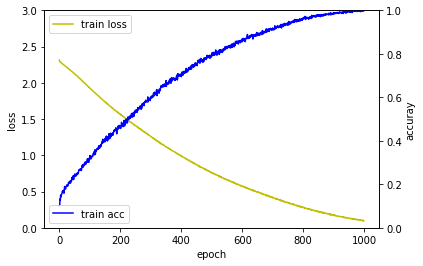

100/100 [==============================] - 0s 436us/step
loss_and_metrics : [8.984135284423829, 0.05]


In [5]:
# 깊은 다층퍼셉트론 신경망 모델

# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 12))
y_train = np.random.randint(10, size=(1000, 1))
y_train = to_categorical(y_train, num_classes=10) # one-hot 인코딩
x_test = np.random.random((100, 12))
y_test = np.random.randint(10, size=(100, 1))
y_test = to_categorical(y_test, num_classes=10) # one-hot 인코딩

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=12, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=1000, batch_size=64)

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 3.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))


이것 역시 퍼셉트론 > 다층퍼셉트론 > 깊은 다층퍼셉트론 순으로 학습이 빨리 되는 것을 확인할 수 있다.